# PXD014381
## Redox proteome analysis identifies reversible oxidized proteins in retinoic acid differentiated SH-SY5Y cells

[PRIDE link](https://www.ebi.ac.uk/pride/archive/projects/PXD014381)

[Article link](https://pubs.acs.org/doi/10.1021/acs.jproteome.9b00752)

In [2]:
#Import libraries
import os
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

# Analysis without LFQ data

In [2]:
#first = pd.read_csv("/home/robbe/ionbot/full_projects/PXD014381_first.csv")
first = pd.read_csv("/home/robbe/ionbot/full_projects_/PXD014381/PXD014381_first.csv")
del first["Unnamed: 0"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].replace('0', 0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

In [3]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  168192
The amount of raw files that make up the master dataset is:  15


In [4]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [5]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,Diamide,500,15,None,0,0,64724
1,None,0,0,None,0,0,39210
2,RA,10,120,None,0,0,24648
3,Retinoic acid,10,120,None,0,0,39610


In [6]:
first.replace("RA", "Retinoic acid", inplace=True)
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()
first.loc[first.spectrum_file == "QX01862", "Oxidant dose (µM)"] = 10
first.loc[first.spectrum_file == "QX01862", "Oxidant treatment"] = "Diamide"

### Conditions that will be compared

| N | Treatment | Treatment 2 | Treatment 3 |
| - | ----------- | ----------- | -------- |
| 1 | Control | Diamide | RA |


In [7]:
Control = first.loc[lambda first: (first["Oxidant treatment"] == "None")]
Diamide = first.loc[lambda first: (first["Oxidant treatment"] == "Diamide")]
RA = first.loc[lambda first: (first["Oxidant treatment"] == "Retinoic acid")]

## Comparison between the treatments

In [8]:
print("There are this many replicates of Control treatment: {}".format(Control["spectrum_file"].nunique()))
print("There are this many replicates of Diamide treatment: {}".format(Diamide["spectrum_file"].nunique()))
print("There are this many replicates of RA treatment: {}".format(RA["spectrum_file"].nunique()))

There are this many replicates of Control treatment: 5
There are this many replicates of Diamide treatment: 5
There are this many replicates of RA treatment: 5


In [9]:
Controlrep = OA.replicate_filter(Control,5)
Diamiderep = OA.replicate_filter(Diamide,5)
RArep = OA.replicate_filter(RA, 5)

In [10]:
print("The ratio of PSMs that contain an oxidative modification in the Control treatment subset: {}".format((Controlrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Diamide treatment subset: {}".format((Diamiderep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the RA treatment subset: {}".format((RArep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the Control treatment subset: 3.3817737335325275 %
The ratio of PSMs that contain an oxidative modification in the Diamide treatment subset: 5.418865996935127 %
The ratio of PSMs that contain an oxidative modification in the RA treatment subset: 4.351471451328917 %


In [11]:
mrControlrep = OA.modratios(Controlrep)
mrDiamiderep = OA.modratios(Diamiderep)
mrRArep = OA.modratios(RArep)

In [12]:
modr_temp = pd.merge(mrDiamiderep, mrRArep, on="Modification", suffixes=('_Diamide', '_RA'))
modr = pd.merge(modr_temp, mrControlrep, on="Modification")
modr = modr.rename(columns={'Ratios':'Ratios_Control'})
modr = modr.drop(modr[(modr["Ratios_Diamide"] == 0) & (modr["Ratios_RA"] == 0) & (modr["Ratios_Control"] == 0)].index)
modr

,Modification,Ratios_Diamide,Ratios_RA,Ratios_Control
2,[35]Oxidation[E],0.000034,0.000000,0.000000
6,[35]Oxidation[I],0.000941,0.000000,0.000000
8,[35]Oxidation[W],0.004447,0.009158,0.000000
11,[35]Oxidation[V],0.000108,0.000077,0.000000
14,[35]Oxidation[Y],0.000183,0.000210,0.000000
16,[35]Oxidation[P],0.000000,0.000000,0.000890
17,[35]Oxidation[N],0.000065,0.000000,0.000000
25,[368]Cys->Dha[C],0.000000,0.000000,0.006527
28,[345]Trioxidation[C],0.006729,0.006329,0.000000
34,[352]Lys->Allysine[K],0.000596,0.000000,0.000000


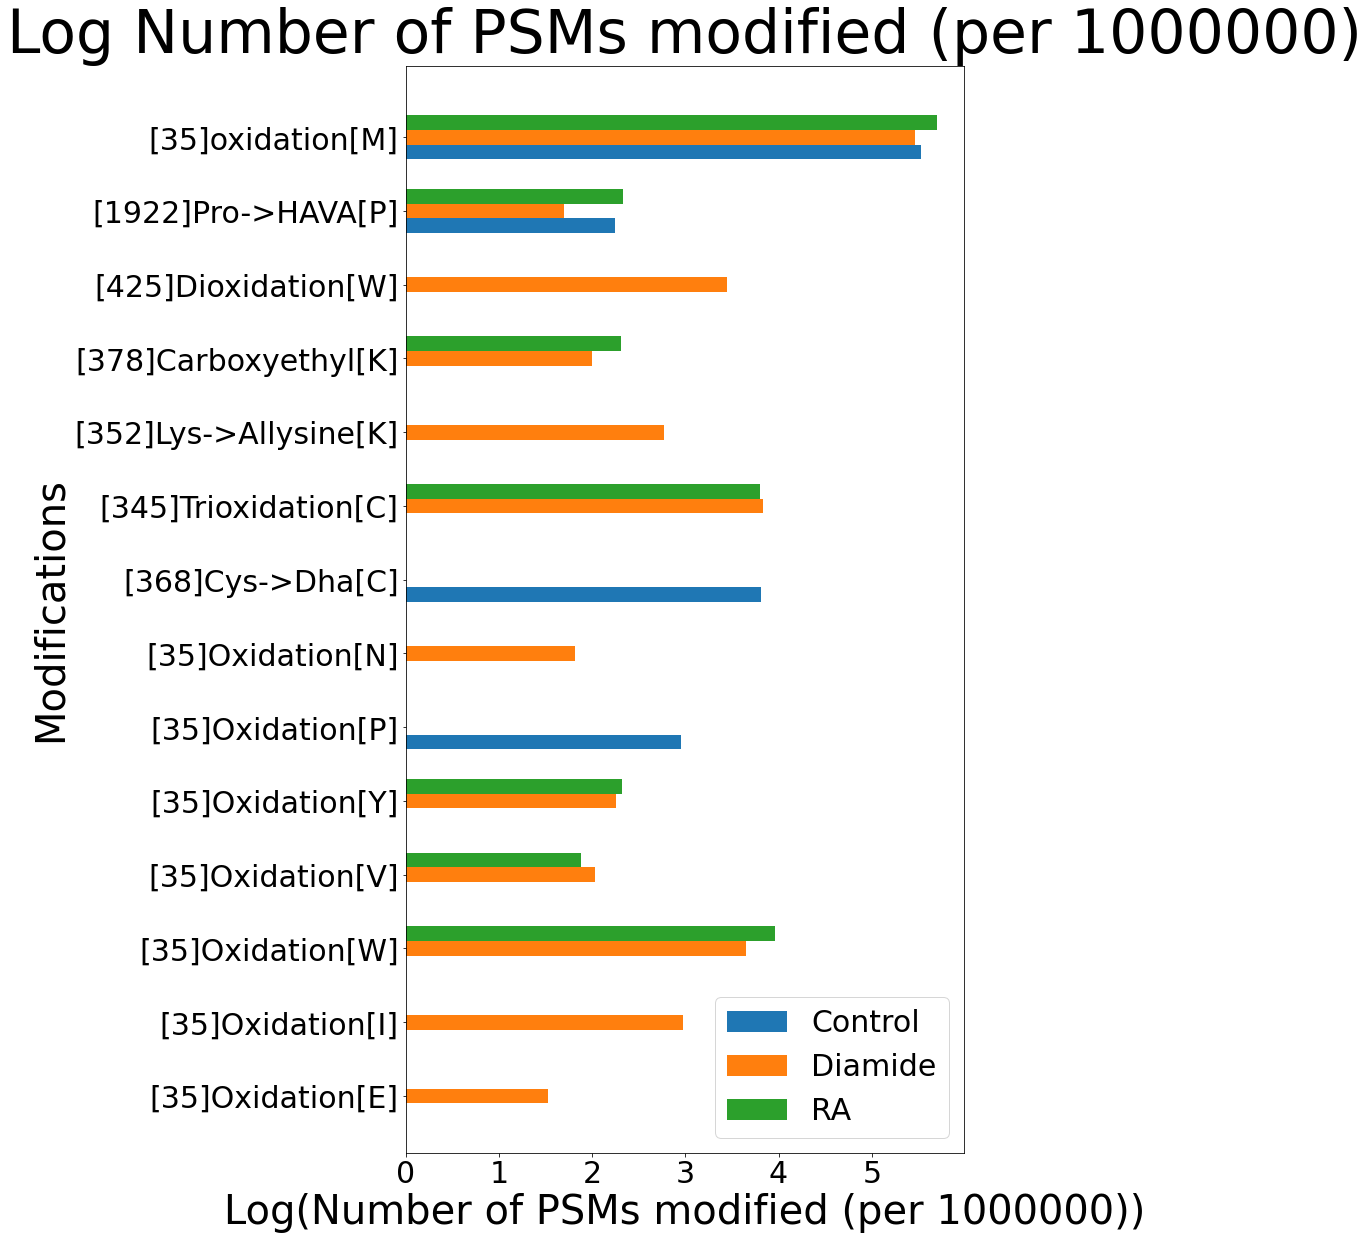

In [13]:
y = modr["Modification"]
xGlu = np.log10(modr['Ratios_Control']*1000000)
xstGal = np.log10(modr['Ratios_Diamide']*1000000)
xltGal = np.log10(modr['Ratios_RA']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(10,20))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'Control')
plt.barh(y_axis, xstGal, 0.2, label = 'Diamide')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'RA')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

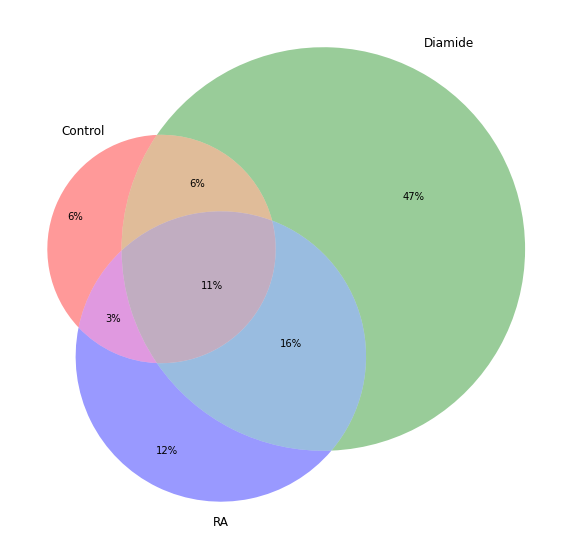

In [14]:
OA.condition_venn([Controlrep,Diamiderep,RArep], ["Control", "Diamide", "RA"])

In [15]:
RPMControl = OA.relative_PSM_modification(Controlrep)
RPMDiamide = OA.relative_PSM_modification(Diamiderep)
RPMRA = OA.relative_PSM_modification(RArep)

In [16]:
RPM = pd.merge(RPMControl, RPMDiamide, on="Amino acid", suffixes=('_Control','_Diamide'))
RPM = pd.merge(RPM, RPMRA, on="Amino acid")
RPM = RPM.rename(columns={"Relative level of PSMs containing unmodified residue" : "Relative level of PSMs containing unmodified residue_RA"})
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_Control,Relative level of PSMs containing unmodified residue_Diamide,Relative level of PSMs containing unmodified residue_RA
0,A,1.000000,1.000000,1.000000
1,R,1.000000,0.999691,0.999401
2,N,0.988066,0.986693,0.991241
3,D,0.998805,0.999144,0.998941
4,C,0.050822,0.050638,0.023768
5,Q,1.000000,0.998273,0.997074
6,E,1.000000,0.998562,0.998168
7,G,1.000000,0.999214,1.000000
8,H,1.000000,0.994772,0.995896
9,I,1.000000,0.998554,1.000000


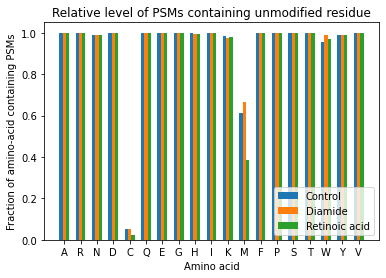

In [17]:
x = RPM["Amino acid"]
xGlu = RPM["Relative level of PSMs containing unmodified residue_Control"]
xst = RPM['Relative level of PSMs containing unmodified residue_Diamide']
xlt = RPM['Relative level of PSMs containing unmodified residue_RA']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'Control')
plt.bar(x_axis, xst, 0.2, label = 'Diamide')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'Retinoic acid')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

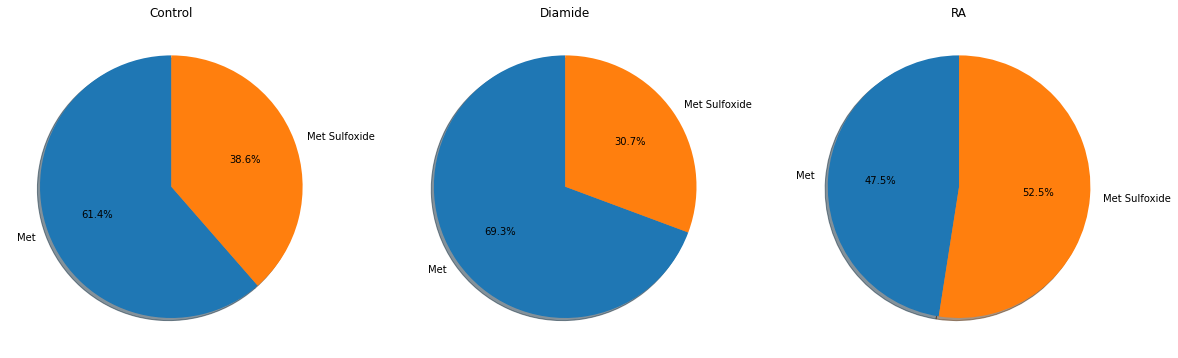

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(Controlrep, ax1)
OA.methionine_overview(Diamiderep, ax2)
OA.methionine_overview(RArep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("Control")
ax2.set_title("Diamide")
ax3.set_title("RA")
plt.show()

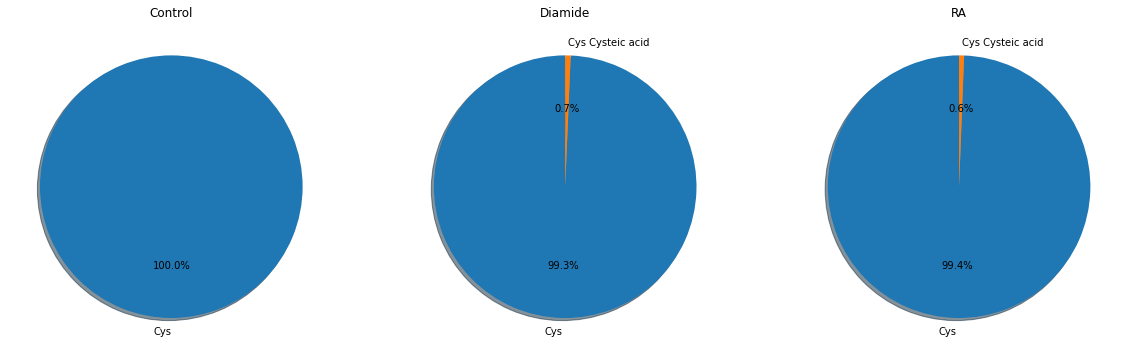

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.cysteine_overview(Controlrep, ax1)
OA.cysteine_overview(Diamiderep, ax2)
OA.cysteine_overview(RArep, ax3)
plt.title("cysteine containing peptides")
ax1.set_title("Control")
ax2.set_title("Diamide")
ax3.set_title("RA")
plt.show()

In [20]:
os.chdir("/home/robbe/ionbot/differentially_oxidized_psms")

In [21]:
diffox, statement = OA.differentially_oxidized_psms(RArep, Controlrep)
with open("diffoxPXD014381.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()

# LFQ analysis

In [2]:
#quant = pd.read_csv("/home/robbe/ionbot/PXD014381/raw_files/QuantifiedPeptides.tsv", sep="\t")
quant = pd.read_csv("/home/robbe/ionbot/ionbot_0.9.5/PXD014381/mzml_files/QuantifiedPeptides.tsv", sep="\t")
quant.drop(list(quant.filter(regex = 'Detection Type|Unnamed')), axis = 1, inplace = True)
quant = quant[~quant["Protein Groups"].str.contains("sp|", na=False, regex=False)]


In [3]:
cols = ['Intensity_QX01983',
       'Intensity_QX01981_160316090220', 'Intensity_QX01867',
       'Intensity_QX01870', 'Intensity_QX01873', 'Intensity_QX01862',
       'Intensity_QX01865', 'Intensity_QX01868', 'Intensity_QX01984',
       'Intensity_QX01874', 'Intensity_QX01860', 'Intensity_QX01863',
       'Intensity_QX01866', 'Intensity_QX01869', 'Intensity_QX01872']

In [4]:
OA.quantile_transform(quant, cols)

,Sequence,Base Sequence,Protein Groups,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872
0,AAAAAAAAAAAAAAAAGATCLER20|[935]Atto495Maleimid...,AAAAAAAAAAAAAAAAGATCLER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAAAAAAGAAGGR0|[1]Acetyl[N-TERM],AAAAAAAAAAGAAGGR,PABP2_HUMAN,NaN,NaN,NaN,NaN,6.121298,5.834774,5.523748,5.969850,6.008275,5.814900,5.310131,6.111347,5.875306,6.006802,6.001351,6.031433,4.350659
2,AAAAAAAAAVSRnan,AAAAAAAAAVSR,ZFP91_HUMAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.248033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAAAAAVPSAGPAGPAPTSAAGR0|[9999530]Methyl_2H(...,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,4.591761,4.455139,4.479478,4.110906,4.311641,4.294662,4.883361,4.690469,4.427945,4.772457,3.814937,3.621315,4.745856,4.482498,4.514642
4,AAAAAAAAVPSAGPAGPAPTSAAGRnan,AAAAAAAAVPSAGPAGPAPTSAAGR,IRS2_HUMAN,NaN,NaN,5.164943,5.006685,5.240198,5.295028,5.566057,5.232198,5.265588,5.261213,4.935918,5.523181,5.284992,5.187497,5.100125,5.137829,5.381597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39163,YYVTIIDAPGHR2|[4]Carbamidomethyl[Y],YYVTIIDAPGHR,NaN,NaN,NaN,5.489817,6.574731,6.515439,6.427139,3.666679,4.921354,5.515669,5.434582,5.857403,NaN,5.734494,6.082803,5.559171,6.234073,6.162652
39164,YYVTIIDAPGHRDFIK16|[320]Nethylmaleimide+water[K],YYVTIIDAPGHRDFIK,NaN,NaN,NaN,3.133248,6.807918,6.676688,4.847939,5.458636,6.341033,4.844949,6.651371,4.514573,6.710468,3.859167,6.509451,6.445864,4.484046,6.530901
39165,YYVTIIDAPGHRnan,YYVTIIDAPGHR,NaN,NaN,NaN,7.770552,8.082394,7.970133,7.948876,7.602078,7.994151,8.040760,8.062211,8.117252,8.129415,7.925919,8.089237,7.991904,8.046757,8.075467
39166,YYVTIIDAPNHR10|Gly->Asn[G],YYVTIIDAPNHR,NaN,NaN,NaN,4.016578,NaN,6.442717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
moddf = OA.summedintensities(quant)

In [6]:
ControlID = ["Modifications", "QX01983","QX01981","QX01867","QX01870","QX01873"]
RAID = ["Modifications", "QX01860","QX01863","QX01866","QX01869","QX01872"]
DiaID = ["Modifications","QX01862","QX01865","QX01868","QX01984","QX01874"]

Controldf = moddf.filter(regex = '|'.join(ControlID))
RAdf = moddf.filter(regex = "|".join(RAID))
Diadf = moddf.filter(regex = "|".join(DiaID))

## Differential modification analysis, specific

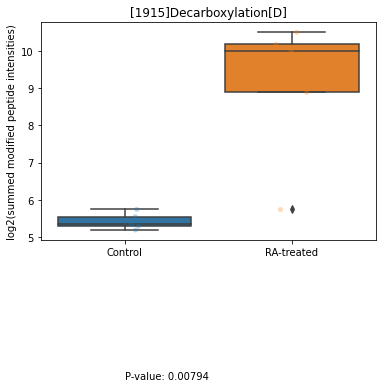

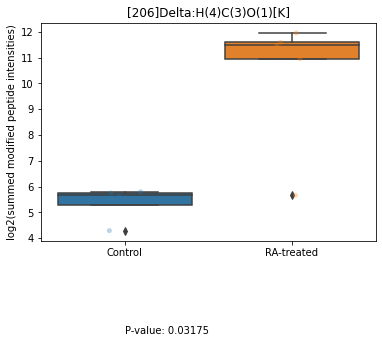

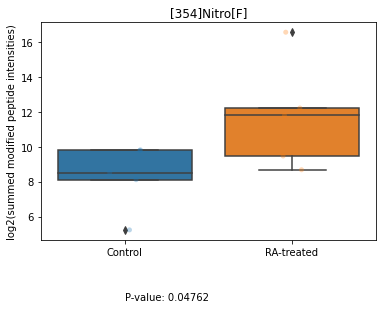

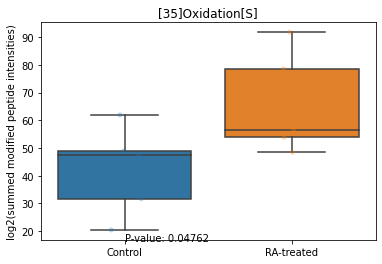

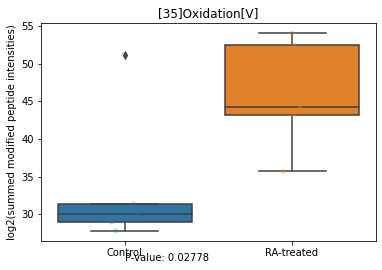

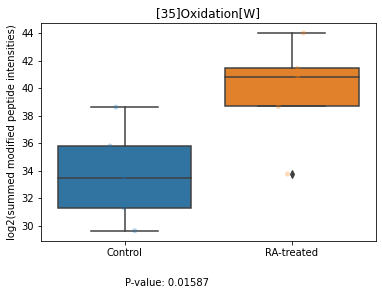

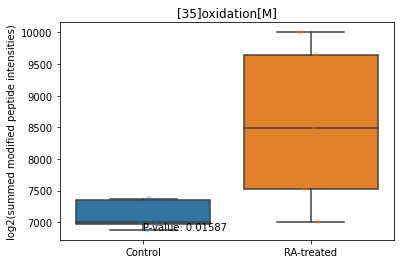

In [7]:
OA.boxplots(Controldf, RAdf, ["Control", "RA-treated"])

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
def boxplots(Control_df, Treatment_df, labels):
    pvallist = []
    for index, row in Control_df.iterrows():
        for index2, row2 in Treatment_df.iterrows():
            if index == index2:
                mod = row["Modifications"]
                dataControl = Control_df.iloc[index][1:]
                dataControl = dataControl.astype(float)
                dataControl = dataControl[dataControl != 0]
                dataTreatment = Treatment_df.iloc[index][1:]
                dataTreatment = dataTreatment.astype(float)
                dataTreatment = dataTreatment[dataTreatment !=0]
                data = [dataControl, dataTreatment] #TODO: #7 Probably better to put both these in a df together, then you can more easily use statannotations
                n_of_tests = Control_df.shape[0]
                
                if dataTreatment.size != 0 and dataControl.size != 0:
                    #One-sided Mann-Whitney U test
                    pval = stats.mannwhitneyu(dataControl,dataTreatment, alternative = 'less').pvalue
                    pvallist.append(pval) 
                    # if pval < 0.05: #TODO: #6 Multiple hypothesis testing correction needed?
                    #     formatted_pvalue = f'P-value = {pval:.2e}'
                    #     fig = plt.figure()
                    #     ax = sns.boxplot(data=data)
                    #     sns.stripplot(data=data, alpha = 0.3)
                    #     ax.set_xticks(range(2))
                    #     ax.set_xticklabels(labels)
                    #     plt.text(x = 0, y = min(min(dataControl), min(dataTreatment))-4, s="P-value: {:.3f}".format(pval))
                    #     plt.title(mod)
                    #     plt.ylabel("log2(summed modified peptide intensities)")
                    #     plt.show()
    corrected_pvals = multipletests(pvallist, method='fdr_bh')[1]
    return pvallist, corrected_pvals

In [9]:
pvallist, corrected_pvals = boxplots(Controldf, RAdf, ["Control", "RA-treated"])

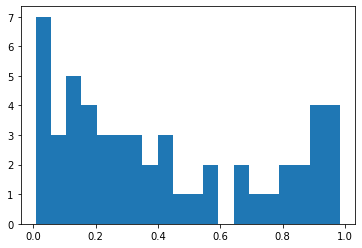

In [10]:
plt.hist(pvallist, bins=20)
plt.show()

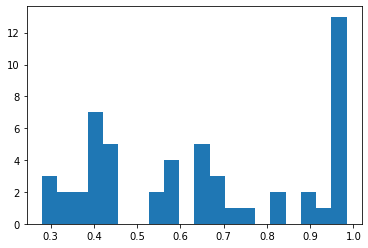

In [11]:
plt.hist(corrected_pvals, bins=20)
plt.show()

In [12]:
corrected_pvals

array([0.8202381 , 0.28042328, 0.63965517, 0.97069597, 0.39960317,
       0.64497354, 0.43170426, 0.97069597, 0.97069597, 0.58888889,
       0.58888889, 0.98412698, 0.9695122 , 0.97069597, 0.82990133,
       0.33650794, 0.42063492, 0.94642857, 0.89304029, 0.43170426,
       0.89304029, 0.75714286, 0.97069597, 0.36054422, 0.42063492,
       0.43170426, 0.67556518, 0.70518207, 0.67556518, 0.42063492,
       0.53080121, 0.53080121, 0.97069597, 0.67556518, 0.63965517,
       0.36054422, 0.43170426, 0.33650794, 0.28042328, 0.42063492,
       0.28042328, 0.97069597, 0.63965517, 0.97069597, 0.97069597,
       0.63965517, 0.58506494, 0.43170426, 0.39960317, 0.58888889,
       0.97069597, 0.39960317, 0.97069597])

## Differential modification analysis, non-specific

In [13]:
moddf.head()

,Modifications,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,Oxmod?
0,[1384]Homocysteic_acid[M],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
1,[1914]Met->AspSA[M],0.0,0.0,13.488623,18.138388,19.742293,18.763777,0.000000,15.265879,9.520877,15.123521,15.349493,6.291211,19.814887,20.496937,10.657975,8.319615,0.000000,8
2,[1915]Decarboxylation[D],0.0,0.0,5.295885,5.336917,5.743652,5.547939,5.188921,5.838175,5.521812,5.592664,5.381616,5.741040,10.179524,10.502476,5.739844,9.990677,8.886380,4
3,[1915]Decarboxylation[E],0.0,0.0,20.184824,6.427488,11.921418,10.150250,11.305552,20.573877,15.388775,17.111557,14.499229,9.802801,10.731322,15.223480,13.700353,9.967196,14.919512,9
4,[1917]Formylasparagine[H],0.0,0.0,0.000000,0.000000,4.583566,4.692016,4.365052,0.000000,0.000000,0.000000,0.000000,4.029567,0.000000,0.000000,0.000000,0.000000,0.000000,2


In [14]:
moddf["UnimodAccession"] = moddf["Modifications"].apply(OA.get_unimod_acc)

In [15]:
Nonspecific = moddf.groupby("UnimodAccession").sum().reset_index()

In [16]:
Nonspecific.head()

,UnimodAccession,Gene Names,Organism,Intensity_QX01983,Intensity_QX01981_160316090220,Intensity_QX01867,Intensity_QX01870,Intensity_QX01873,Intensity_QX01862,Intensity_QX01865,Intensity_QX01868,Intensity_QX01984,Intensity_QX01874,Intensity_QX01860,Intensity_QX01863,Intensity_QX01866,Intensity_QX01869,Intensity_QX01872,Oxmod?
0,1384,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
1,1914,0.0,0.0,13.488623,18.138388,19.742293,18.763777,0.000000,15.265879,9.520877,15.123521,15.349493,6.291211,19.814887,20.496937,10.657975,8.319615,0.000000,8
2,1915,0.0,0.0,25.480709,11.764405,17.665070,15.698189,16.494473,26.412052,20.910587,22.704221,19.880846,15.543841,20.910846,25.725956,19.440197,19.957873,23.805892,13
3,1917,0.0,0.0,0.000000,0.000000,4.583566,4.692016,4.365052,0.000000,0.000000,0.000000,0.000000,4.029567,0.000000,0.000000,0.000000,0.000000,0.000000,2
4,1918,0.0,0.0,62.063751,67.504328,77.161049,78.862940,59.632062,80.200422,74.152114,78.722102,70.726890,61.948006,76.041923,68.509851,76.498527,75.657586,62.151808,32


In [17]:
ControlID = ["UnimodAccession", "QX01983","QX01981","QX01867","QX01870","QX01873"]
RAID = ["UnimodAccession", "QX01860","QX01863","QX01866","QX01869","QX01872"]
DiaID = ["UnimodAccession","QX01862","QX01865","QX01868","QX01984","QX01874","QX01983"]

Controldf = Nonspecific.filter(regex = '|'.join(ControlID))
RAdf = Nonspecific.filter(regex = "|".join(RAID))

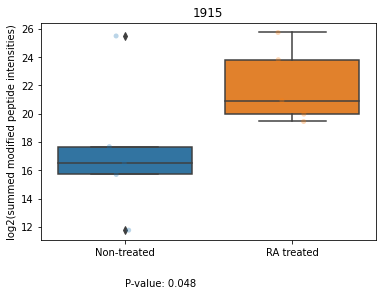

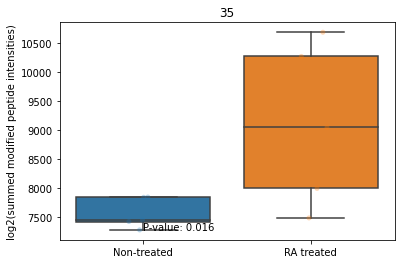

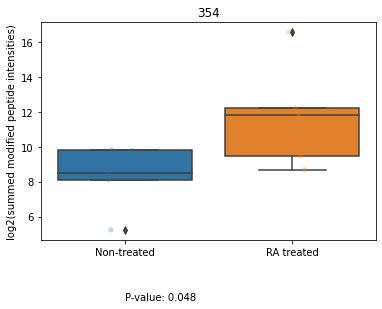

In [18]:
OA.boxplots_not_specific(Controldf, RAdf, ["Non-treated", "RA treated"])

In [19]:
pvallist, corrected_pvals = OA.multipletest(Controldf, RAdf)

<function matplotlib.pyplot.show(close=None, block=None)>

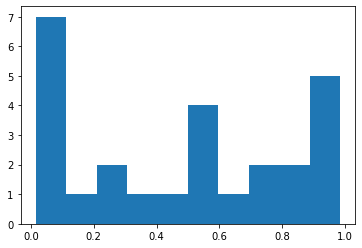

In [20]:
plt.hist(pvallist)
plt.show

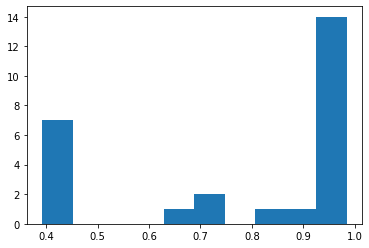

In [21]:
plt.hist(corrected_pvals)
plt.show()

## Oxidation distributions of methionine and cysteine


In [22]:
Nonmodified = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("M")]
Sulfoxide = quant.loc[quant["Sequence"].str.contains("[35]oxidation[M]",regex=False)]
Sulfone = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[M]", regex = False)]
Homocysteic_acid = quant.loc[quant["Sequence"].str.contains("[1384]Homocysteic_acid[M]", regex = False)]
Nonmodifiednums = Nonmodified.append(Nonmodified.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfoxidenums = Sulfoxide.append(Sulfoxide.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfonenums = Sulfone.append(Sulfone.sum(numeric_only=True), ignore_index=True)[-1:]
Homocysteicnums = Homocysteic_acid.append(Homocysteic_acid.sum(numeric_only=True), ignore_index= True)[-1:]
moddf = [Nonmodifiednums, Sulfoxidenums, Sulfonenums, Homocysteicnums]

In [23]:
Controldict = {}
RAdict = {}
for i, df in enumerate(moddf):
    df = df.filter(regex=r'QX')
    Controlsub = df.loc[:, df.columns.str.contains("|".join(ControlID))]
    RAsub = df.loc[:, df.columns.str.contains("|".join(RAID))]
    Controlsum = Controlsub.sum(axis=1)
    RAsum = RAsub.sum(axis=1)
    Controldict[i] = Controlsum.values[0]
    RAdict[i] = RAsum.values[0]

In [24]:
Controldict

{0: 43635.95608038436, 1: 34933.244061151614, 2: 0.0, 3: 0.0}

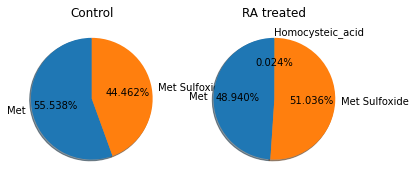

In [25]:
labelsH = ["Met", "Met Sulfoxide"]
labelsC = ["Met", "Met Sulfoxide", "Homocysteic_acid"]
sizesC = []
sizesT = []
for x, y in Controldict.items():
    if y != 0:
        sizesC.append(y)
for x, y in RAdict.items():
    if y != 0:
        sizesT.append(y)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizesC, labels=labelsH, autopct='%1.3f%%', shadow= True, startangle = 90)
ax2.pie(sizesT, labels=labelsC, autopct='%1.3f%%', shadow= True, startangle= 90)
plt.title("Methionine containing peptides")
ax1.set_title("Control")
ax2.set_title("RA treated")
plt.show()

In [26]:
NonmodifiedC = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("C")]
Sulfenic = quant.loc[quant["Sequence"].str.contains("[35]oxidation[C]",regex=False)]
Sulfinic = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[C]", regex = False)]
Cysteic = quant.loc[quant["Sequence"].str.contains("[345]Trioxidation[C]", regex = False)]
Non_modified = NonmodifiedC.append(NonmodifiedC.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfenic_acid = Sulfenic.append(Sulfenic.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfinic_acid = Sulfinic.append(Sulfinic.sum(numeric_only=True), ignore_index=True)[-1:]
Cysteic_acid = Cysteic.append(Cysteic.sum(numeric_only=True), ignore_index=True)[-1:]
moddfc = [Non_modified, Sulfenic_acid, Sulfinic_acid, Cysteic_acid]

In [27]:
Controldict = {}
RAdict = {}
for i in moddfc:
    name = OA.retrieve_name(i)[1]
    df = i.filter(regex=r'QX')
    Controlsub = df.loc[:, df.columns.str.contains("|".join(ControlID))]
    RAsub = df.loc[:, df.columns.str.contains("|".join(RAID))]
    Controlsum = Controlsub.sum(axis=1)
    RAsum = RAsub.sum(axis=1)
    Controldict[name] = Controlsum.values[0]
    RAdict[name] = RAsum.values[0]

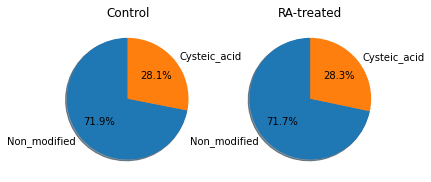

In [28]:
labelsC = []
labelsT = []
sizesC = []
sizesT = []

for x, y in Controldict.items():
    if y != 0:
        labelsC.append(x)
        sizesC.append(y)
for x, y in RAdict.items():
    if y != 0:
        labelsT.append(x)
        sizesT.append(y)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizesC, labels=labelsC, autopct='%1.1f%%', shadow= True, startangle = 90)
ax2.pie(sizesT, labels=labelsT, autopct='%1.1f%%', shadow= True, startangle= 90)
ax1.set_title("Control")
ax2.set_title("RA-treated")
plt.show()

In [5]:
path = "/home/robbe/ionbot/ionbot_0.9.5/PXD014381/ionbot_files"
subdirs = [dirname for dirname in os.listdir(path)]
control = ["QX01983","QX01981","QX01867","QX01870","QX01873"]
RA = ["QX01860","QX01863","QX01866","QX01869","QX01872"]

In [6]:
oxidated_proteins = set()
oxidated_proteins_controls = set()
for subdir in subdirs:
    if subdir in RA:
        with open(path + "/" + subdir + "/ionbot.modifications.csv") as fn:
            for line in fn.readlines():
                linelist = line.split(",")
                unexpected_modification = linelist[2]
                protein = linelist[1]
                if "Oxidation" in unexpected_modification and not "sp" in protein:
                    oxidated_proteins.add(protein)

    if subdir in control:
        with open(path + "/" + subdir + "/ionbot.modifications.csv") as fn:
            for line in fn.readlines():
                linelist = line.split(",")
                unexpected_modification = linelist[2]
                protein = linelist[1]
                if "Oxidation" in unexpected_modification and not "sp" in protein:
                    oxidated_proteins_controls.add(protein)

oxidated_proteins_controlled = oxidated_proteins - oxidated_proteins_controls


In [9]:
for i in oxidated_proteins_controlled: print(i)

O60506
P52701
P60842
P61313
O14980
A0A075B759
P54578
P46777
P20073
Q9Y4G6
P62829
Q8NBQ5
Q9UHD8
Q9P2J5
Q08211
P06744
P14618
Q9BYF1
Q96E39
O00232
P48047
P61160
P02771
P19367
F5H284
P12235
P61978
P50395
P00558
P39023
O00410
P62826
Q13617
Q15365
Q14568
A0A075B767
P53396
P30613
P38606
P62805
Q15008
Q92616
Q6ZMR3
P62701
P23396
P25705
Q01518
Q9NUQ9
P62258
P21796
Q32P51
P36578
P08240
Q71UM5
Q9Y383
P37802
Q12931
P46087
P50990
P62879
P12814
Q99714
P12004
Q16658
Q9UI15
Q7L1Q6
Q9H0D6
Q9BUJ2
Q9NR30
P38159
Q9Y394
O75396
Q93084
P06576
Q13263
P35222
P09651
P16615
P42677
P07864
P17987
O00154
P98198
P20700
Q9UGI8
P07195
P04632
Q01082
Q00610
P13639
P53675
P10809
Q9NZL4
Q9UBH6
P62304
Q14157
P00338
P05026
P31150
Q9H0Q0
A0A0B4J2A2
P62937
Q9H853
P38919
P13647
P12236
P62888
Q9Y536
